In [1]:
# header files
import torch
import torch.nn as nn
import torchvision
from torch.optim import lr_scheduler
import torch.utils.model_zoo as model_zoo
import numpy as np
import skimage
from skimage import io, transform
import glob
import csv
from PIL import Image
import time
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
#from torch.utils.tensorboard import SummaryWriter

In [2]:
# ensure same result is produced
torch.backends.cudnn.benchmark = True
np.random.seed(1234)
torch.manual_seed(1234)
torch.cuda.manual_seed(1234)

In [3]:
# dataset paths
train_path = glob.glob("data/qcdata_1channel/final_train*")
val_path = glob.glob("data/qcdata_1channel/final_val*")

In [4]:
# hyperparameters
image_size = 1024    #512 or 1024
is_pretrained = False    #True or False

lr = 0.001
batch_size = 12
num_epochs = 51
output_classes = 4

In [5]:
# create PyTorch dataset class
class ImageQC_Dataset(torch.utils.data.Dataset):
    """
        ImageQC Dataset.
    """
    
    # init method
    def __init__(self, files, img_size=1024):
        """
        Args:
            root (string): path of the directory which contains the required images and masks
            transform (torchvision.transforms): transforms applied on the given image
            img_size: random crop to be taken during training
        """
        self.files = files
        self.img_size = img_size
        
        # get the file paths and their corresponding labels
        self.image_path_0 = []
        self.image_path_1 = []
        self.image_path_2 = []
        self.image_path_3 = []
        
        self.labels = []
        self.image_path = []
        for file in files:
            flag = -1
    
            with open(file, newline='') as csvfile:
                spamreader = csv.reader(csvfile)
                for row in spamreader:
                    if flag == -1:
                        flag = 1
                    else:
                        array = row
                        fixed_path = "/dgx1nas1/cellpainting-datasets/2019_07_11_JUMP_CP_pilots"
                        image_path = array[0].split("/")
                        
                        if image_path[1] == "dgx1nas1":
                            if int(array[1]) == 0:
                                self.image_path_0.append(str(array[0]))
                            elif int(array[1]) == 1:
                                self.image_path_1.append(str(array[0]))
                            elif int(array[1]) == 2:
                                self.image_path_2.append(str(array[0]))
                            elif int(array[1]) == 3:
                                self.image_path_3.append(str(array[0]))
                        else:
                            new_image_path = fixed_path
                            for index in range(3, len(image_path)):
                                new_image_path = new_image_path + "/" + image_path[index]
                                
                            if int(array[1]) == 0:
                                self.image_path_0.append(str(new_image_path))
                            elif int(array[1]) == 1:
                                self.image_path_1.append(str(new_image_path))
                            elif int(array[1]) == 2:
                                self.image_path_2.append(str(new_image_path))
                            elif int(array[1]) == 3:
                                self.image_path_3.append(str(new_image_path))
        

        # append images and labels
        for index in range(0, len(self.image_path_0)):
            self.image_path.append(self.image_path_0[index])
            self.labels.append("0")
        
        for index in range(0, len(self.image_path_1)):
            self.image_path.append(self.image_path_1[index])
            self.labels.append("1")
            
        for index in range(0, len(self.image_path_2)):
            self.image_path.append(self.image_path_2[index])
            self.labels.append("2")
            
        for index in range(0, len(self.image_path_3)):
            self.image_path.append(self.image_path_3[index])
            self.labels.append("3")
            
        #print(len(self.image_path_0))
        #print(len(self.image_path_1))
        #print(len(self.image_path_2))
        #print(len(self.image_path_3))
        
                
    # getitem method
    def __getitem__(self, index):
        """
        Args:
            index (int): Index
        """
        # read each channel
        image = skimage.io.imread(self.image_path[index], plugin='pil')
        
        # resize each channel
        image = skimage.transform.resize(image, [self.img_size, self.img_size], mode='constant', preserve_range=True, order=0)
        
        # convert each channel to type uint8
        if float(image.max()) > 0.0:
            image = image / float(image.max())
            image = 255. * image
        
        # convert them to PyTorch tensor
        image = torch.from_numpy(np.array(image).astype('uint8'))
        
        # normalize the images and merge
        image = image / 255.
        image = image.unsqueeze(0)
        
        # label
        label = int(self.labels[index])
        
        # return the image and the corresponding label
        return image, label

    # len method
    def __len__(self):
        """
        Returns:
            int: number of images in the directory
        """
        return len(self.labels)

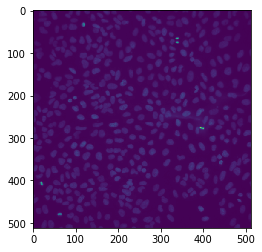

In [6]:
# view images
dataset = ImageQC_Dataset(train_path, img_size=image_size)
plt.imshow(dataset.__getitem__(5)[0].numpy()[0])

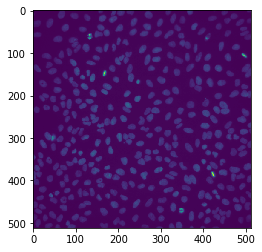

In [7]:
# view images
dataset = ImageQC_Dataset(train_path, img_size=image_size)
plt.imshow(dataset.__getitem__(15)[0].numpy()[0])

In [8]:
# handling class imbalance during training 
class ImbalancedDatasetSampler(torch.utils.data.sampler.Sampler):
    """Samples elements randomly from a given list of indices for imbalanced dataset
    Arguments:
        indices (list, optional): a list of indices
        num_samples (int, optional): number of samples to draw
        callback_get_label func: a callback-like function which takes two arguments - dataset and index
    """

    def __init__(self, dataset, indices=None, num_samples=None, callback_get_label=None, weights=None):
                
        # if indices is not provided, all elements in the dataset will be considered
        self.indices = list(range(len(dataset))) if indices is None else indices

        # define custom callback
        self.callback_get_label = callback_get_label

        # if num_samples is not provided, draw `len(indices)` samples in each iteration
        self.num_samples = len(self.indices) if num_samples is None else num_samples
            
        # distribution of classes in the dataset 
        label_to_count = {}
        label_to_count[0] = 13448
        label_to_count[1] = 400
        label_to_count[2] = 1812
        label_to_count[3] = 3349
                
        # weight for each sample
        if weights == None:
            weights = [1.0 / label_to_count[self._get_label(dataset, idx)] for idx in self.indices]
        self.weights = torch.DoubleTensor(weights)

    def _get_label(self, dataset, idx):
        if self.callback_get_label:
            return self.callback_get_label(dataset, idx)
        elif isinstance(dataset, torchvision.datasets.MNIST):
            return dataset.train_labels[idx].item()
        elif isinstance(dataset, torchvision.datasets.ImageFolder):
            return dataset.imgs[idx][1]
        elif isinstance(dataset, torch.utils.data.Subset):
            return dataset.dataset.imgs[idx][1]
        else:
            return dataset.__getitem__(idx)[1]
                
    def __iter__(self):
        return (self.indices[i] for i in torch.multinomial(self.weights, self.num_samples, replacement=True))

    def __len__(self):
        return self.num_samples

In [9]:
# create PyTorch dataset class and create train data and val data
train_data = ImageQC_Dataset(train_path, img_size=image_size)
val_data = ImageQC_Dataset(val_path, img_size=image_size)
print(len(train_data))
print(len(val_data))

19009
800


In [10]:
# load the data
weights = []
for index in range(0, 13448):
    weights.append(1. / 13448)
for index in range(0, 400):
    weights.append(1. / 400)
for index in range(0, 1812):
    weights.append(1. / 1812)
for index in range(0, 3349):
    weights.append(1. / 3349)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=24, sampler=ImbalancedDatasetSampler(train_data, weights=weights))
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=24)

In [11]:
# model
model = torchvision.models.resnet50(pretrained=is_pretrained)
if is_pretrained:
    for param in model.parameters():
        param.requires_grad = False
model.conv1 = torch.nn.Sequential(
    torch.nn.Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
    torch.nn.BatchNorm2d(3),
    torch.nn.ReLU(inplace=True),
    torch.nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
)
model.fc = torch.nn.Sequential(
    torch.nn.Linear(2048, 512),
    torch.nn.ReLU(),
    torch.nn.Dropout(),
    torch.nn.Linear(512, output_classes)
)
    
# load model to gpu
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
model.to(device)

# load tensorboard
#%load_ext tensorboard
#%tensorboard --logdir logs

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [12]:
# define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [13]:
# Cross-Entropy loss with Label Smoothing
class CrossEntropyLabelSmoothingLoss(nn.Module):
    
    def __init__(self, smoothing=0.0):
        super(CrossEntropyLabelSmoothingLoss, self).__init__()
        self.smoothing = smoothing
    
    def forward(self, pred, target):
        log_prob = torch.nn.functional.log_softmax(pred, dim=-1)
        weight = input.new_ones(pred.size()) * (self.smoothing/(pred.size(-1)-1.))
        weight.scatter_(-1, target.unsqueeze(-1), (1.-self.smoothing))
        loss = (-weight * log_prob).sum(dim=-1).mean()
        return loss

In [14]:
# define loss (smoothing=0 is equivalent to standard Cross-Entropy loss)
criterion = CrossEntropyLabelSmoothingLoss(0.0)

In [15]:
# metrics class
class _StreamMetrics(object):
    def __init__(self):
        """ Overridden by subclasses """
        raise NotImplementedError()

    def update(self, gt, pred):
        """ Overridden by subclasses """
        raise NotImplementedError()

    def get_results(self):
        """ Overridden by subclasses """
        raise NotImplementedError()

    def to_str(self, metrics):
        """ Overridden by subclasses """
        raise NotImplementedError()

    def reset(self):
        """ Overridden by subclasses """
        raise NotImplementedError()      

class StreamMetrics(_StreamMetrics):
    """
    Stream Metrics for Semantic Segmentation Task
    """
    def __init__(self, n_classes):
        self.n_classes = n_classes
        self.confusion_matrix = np.zeros((n_classes, n_classes))

    def update(self, label_trues, label_preds):
        for lt, lp in zip(label_trues, label_preds):
            self.confusion_matrix += self._fast_hist( lt.flatten(), lp.flatten() )
    
    @staticmethod
    def to_str(results):
        string = "\n"
        for k, v in results.items():
            if k!="Class IoU":
                string += "%s: %f\n"%(k, v)
        
        #string+='Class IoU:\n'
        #for k, v in results['Class IoU'].items():
        #    string += "\tclass %d: %f\n"%(k, v)
        return string

    def _fast_hist(self, label_true, label_pred):
        mask = (label_true >= 0) & (label_true < self.n_classes)
        hist = np.bincount(
            self.n_classes * label_true[mask].astype(int) + label_pred[mask],
            minlength=self.n_classes ** 2,
        ).reshape(self.n_classes, self.n_classes)
        return hist

    def get_results(self):
        """Returns accuracy score evaluation result.
            - overall accuracy
            - mean accuracy
            - mean IU
            - fwavacc
        """
        hist = self.confusion_matrix
        acc = np.diag(hist).sum() / hist.sum()
        acc_cls = np.diag(hist) / hist.sum(axis=1)
        acc_cls = np.nanmean(acc_cls)
        iu = np.diag(hist) / (hist.sum(axis=1) + hist.sum(axis=0) - np.diag(hist))
        mean_iu = np.nanmean(iu)
        freq = hist.sum(axis=1) / hist.sum()
        fwavacc = (freq[freq > 0] * iu[freq > 0]).sum()
        cls_iu = dict(zip(range(self.n_classes), iu))

        return {
                "Overall Acc": acc,
                "Mean Acc": acc_cls,
                "FreqW Acc": fwavacc,
                "Mean IoU": mean_iu,
                "Class IoU": cls_iu,
                "Confusion Matrix": hist
            }
        
    def reset(self):
        self.confusion_matrix = np.zeros((self.n_classes, self.n_classes))

class AverageMeter(object):
    """Computes average values"""
    def __init__(self):
        self.book = dict()

    def reset_all(self):
        self.book.clear()
    
    def reset(self, id):
        item = self.book.get(id, None)
        if item is not None:
            item[0] = 0
            item[1] = 0

    def update(self, id, val):
        record = self.book.get(id, None)
        if record is None:
            self.book[id] = [val, 1]
        else:
            record[0]+=val
            record[1]+=1

    def get_results(self, id):
        record = self.book.get(id, None)
        assert record is not None
        return record[0] / record[1]

In [16]:
metrics = StreamMetrics(output_classes)
best_metric = -1
best_confusion_matrix = -1
best_metric_epoch = -1
train_loss = []
val_loss = []
train_acc = []
val_acc = []
confusion_matrix = None
#writer = SummaryWriter("./logs/")
#writer.flush()

# train and validate
for epoch in range(0, num_epochs):
    print("Epoch: " + str(epoch))
    print()
    
    # train
    metrics.reset()
    model.train()
    training_loss = 0.0
    total = 0
    correct = 0
    for i, (input, target) in enumerate(train_loader):
        input = input.to(device)
        target = target.to(device)

        optimizer.zero_grad()
        output = model(input)
        loss = criterion(output, target)
        
        loss.backward()
        optimizer.step()
        
        training_loss = training_loss + loss.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()
        
    training_loss = training_loss/float(len(train_loader))
    training_accuracy = str(100.0*(float(correct)/float(total)))
    train_acc.append(training_accuracy)
    train_loss.append(training_loss)
    
    #writer.add_scalar("Loss/train", float(training_loss), epoch)
    #writer.add_scalar("Accuracy/train", float(training_accuracy), epoch)
    
    # validate
    if epoch%5 == 0:
        metrics.reset()
        model.eval()
        valid_loss = 0.0
        total = 0
        correct = 0
        for i, (input, target) in enumerate(val_loader):
            with torch.no_grad():
                input = input.to(device)
                target = target.to(device)

                output = model(input)
                loss = criterion(output, target)
                _, predicted = output.max(1)
                total += target.size(0)
                correct += predicted.eq(target).sum().item()
                
                # get confusion matrix
                targets = target.cpu().numpy()
                predicted = predicted.cpu().numpy()
                metrics.update(targets, predicted)
            
            valid_loss = valid_loss + loss.item()
        valid_loss = valid_loss/float(len(val_loader))
        valid_accuracy = str(100.0*(float(correct)/float(total)))
        results = metrics.get_results()
        confusion_matrix = results["Confusion Matrix"]
        val_loss.append(valid_loss)
        val_acc.append(valid_accuracy)
        #writer.add_scalar("Loss/val", float(valid_loss), epoch)
        #writer.add_scalar("Accuracy/val", float(valid_accuracy), epoch)

        # store best model
        if(float(valid_accuracy)>best_metric):
            best_metric = float(valid_accuracy)
            best_metric_epoch = epoch
            best_confusion_matrix = confusion_matrix
            #torch.save(model.state_dict(), "/home/jupyter-arpit@broadinstitu-ef612/qc_bestmodel_baseline_1channel_lr2_size2.pth")
    
        print()
        print("Epoch" + str(epoch) + ":")
        print("Training Accuracy: " + str(training_accuracy) + "    Validation Accuracy: " + str(valid_accuracy))
        print("Training Loss: " + str(training_loss) + "    Validation Loss: " + str(valid_loss))
        print("Best metric: " + str(best_metric))
        print(confusion_matrix)
        print(best_confusion_matrix)
        print()
    
    # lr scheduler
    lr_scheduler.step()
    
    
# close tensorboard writer
#writer.flush()
#writer.close()

Epoch: 0


Epoch0:
Training Accuracy: 71.87121889631227    Validation Accuracy: 72.75
Training Loss: 0.6925973476514957    Validation Loss: 0.7251109629869461
Best metric: 72.75
[[134.  31.   8.  27.]
 [  0. 192.   0.   8.]
 [  0.   0. 197.   3.]
 [ 32. 101.   8.  59.]]

Epoch: 1

Epoch: 2

Epoch: 3

Epoch: 4

Epoch: 5


Epoch5:
Training Accuracy: 79.23615129675416    Validation Accuracy: 74.0
Training Loss: 0.5426056160661074    Validation Loss: 0.8427459522383287
Best metric: 74.0
[[136.  30.   8.  26.]
 [  0. 197.   0.   3.]
 [  0.   1. 197.   2.]
 [ 26. 103.   9.  62.]]

Epoch: 6

Epoch: 7

Epoch: 8

Epoch: 9

Epoch: 10


Epoch10:
Training Accuracy: 83.60776474301646    Validation Accuracy: 78.75
Training Loss: 0.4422793405837566    Validation Loss: 0.503142423555255
Best metric: 78.75
[[149.   8.   7.  36.]
 [  0. 158.   0.  42.]
 [  3.   0. 195.   2.]
 [ 37.  29.   6. 128.]]

Epoch: 11

Epoch: 12

Epoch: 13

Epoch: 14

Epoch: 15


Epoch15:
Training Accuracy: 84.45473196906728    

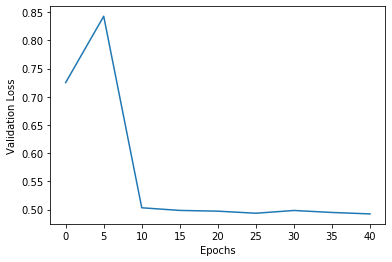

In [17]:
# val_loss vs epoch
epoch = []
for i in range(0, len(val_acc)):
    epoch.append(i*5)
    val_acc[i] = float(val_acc[i])
    val_loss[i] = float(val_loss[i])
    
plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
plt.plot(epoch, val_loss)
#plt.savefig("/home/jupyter-arpit@broadinstitu-ef612/val_loss_qc_baseline_1channel_lr2_size2.png")
plt.show()

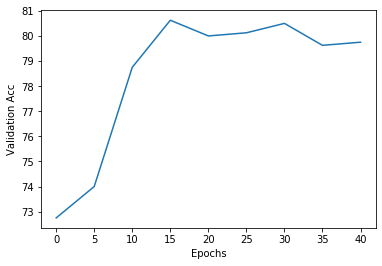

In [18]:
# val_loss vs epoch
epoch = []
for i in range(0, len(val_acc)):
    epoch.append(i*5)
    val_acc[i] = float(val_acc[i])
    val_loss[i] = float(val_loss[i])
    
plt.xlabel("Epochs")
plt.ylabel("Validation Acc")
plt.plot(epoch, val_acc)
#plt.savefig("/home/jupyter-arpit@broadinstitu-ef612/val_acc_qc_baseline_1channel_lr2_size2.png")
plt.show()

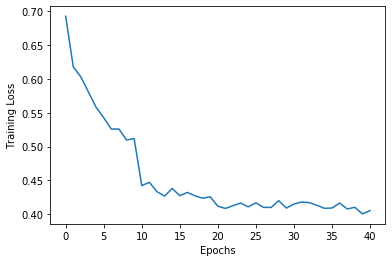

In [19]:
# train_loss vs epoch
epoch = []
for i in range(0, len(train_acc)):
    epoch.append(i)
    train_acc[i] = float(train_acc[i])
    train_loss[i] = float(train_loss[i])
    
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.plot(epoch, train_loss)
#plt.savefig("/home/jupyter-arpit@broadinstitu-ef612/train_loss_qc_baseline_1channel_lr2_size2.png")
plt.show()

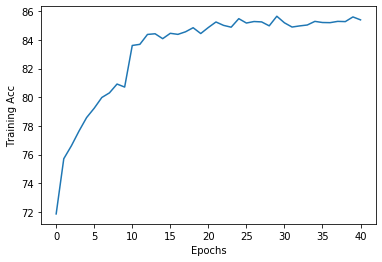

In [20]:
# train_loss vs epoch
epoch = []
for i in range(0, len(train_acc)):
    epoch.append(i)
    train_acc[i] = float(train_acc[i])
    train_loss[i] = float(train_loss[i])
    
plt.xlabel("Epochs")
plt.ylabel("Training Acc")
plt.plot(epoch, train_acc)
#plt.savefig("/home/jupyter-arpit@broadinstitu-ef612/train_acc_qc_baseline_1channel_lr2_size2.png")
plt.show()